In [1]:
#import cv2
import numpy as np
np.set_printoptions(threshold = np.inf)
#import pydicom
import matplotlib.pyplot as plt
#import dicom2nifti
#import nibabel as nib
import scipy
import sys
#from sklearn import preprocessing

import os
import pandas as pd
from scipy.ndimage import label
from scipy.ndimage.morphology import generate_binary_structure
import SimpleITK as sitk
print(sitk.Version())
from pathlib import Path
#from nipype.interfaces.ants import N4BiasFieldCorrection
import skimage.io as io
#import fsl
import itk
from shutil import copy

/tmp/ipykernel_2891223/3281519880.py:15: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import generate_binary_structure


SimpleITK Version: 2.3.1 (ITK 5.3)
Compiled: Nov  1 2023 12:24:28



## Function 

1. CT_prerprocess: CT preprocessing code
2. ReOri_ReDir: reset the origin and direction to fixed
3. show_img: show the image by dimension
4. load_img: load data with nifti/array foramt
5. coRegis: mapping the moving img to the fixed img center

In [2]:
def adjust_array(ori_direction, ori_array):
    print('ori_dir, ori_origin: ',ori_array.GetDirection(), ', ', ori_array.GetOrigin())
    ori_ori, ori_dir = ori_array.GetOrigin(),ori_array.GetDirection()
    ori_array = sitk.GetArrayFromImage(ori_array)
    print(ori_array.shape)
    if ori_direction[0] == -1.0:
        print('flip on axis 2')
        np.flip(ori_array, axis = 2)
    if ori_direction[4] == -1.0:
        np.flip(ori_array, axis = 1)
        print('flip on axis 1')
    if ori_direction[8] == -1.0:
        np.flip(ori_array, axis = 0)
        print('flip on axis 0')
        
    transfer_array = sitk.GetImageFromArray(ori_array)
    transfer_array.SetOrigin(ori_ori)
    print('transfer_dir, transfer_origin: ',transfer_array.GetDirection(), ', ', transfer_array.GetOrigin())   
    
    return transfer_array

In [3]:
def adjust_direction(object_example, ori_example):
    print('ori_dir, ori_origin: ',ori_example.GetDirection(), ', ', ori_example.GetOrigin())
    ori_ori = ori_example.GetOrigin()
    ori_dir = ori_example.GetDirection()
    print('object_dir, object_ori: ',object_example.GetDirection(), ', ', object_example.GetOrigin())
    object_ori= object_example.GetOrigin()
    object_dir = object_example.GetDirection()
#     ori_example = sitk.GetArrayFromImage(ori_example)
    ori_example = sitk.GetArrayFromImage(ori_example)
    print(ori_example.shape)
    if ori_dir[0] != object_dir[0]:
        print('different axis 2')
        np.flip(ori_example, axis = 2)
        
    if ori_dir[4] != object_dir[4]:
        print('different axis 1')
        np.flip(ori_example, axis = 1)
        print(ori_example.shape)
        
    if ori_dir[8] != object_dir[8]:
        print('different axis 0')
        np.flip(ori_example, axis = 0)
    
    print(ori_example.shape)
    transfer_array = sitk.GetImageFromArray(ori_example)
#     print(ori_example_output.shape)
    transfer_array = transfer_array.SetOrigin(object_ori)
 #   print(ori_example_output.shape)
#     print('transfer_dir, transfer_origin: ',ori_example_output.GetDirection(), ', ', ori_example_output.GetOrigin())   
    
    return transfer_array

In [4]:
def sitk2itk(sitk_img, IMAGE_DIMENSION):
    npsitk_img = sitk.GetArrayFromImage(sitk_img)
    itk_img = itk.GetImageFromArray(npsitk_img)
    itk_img.SetOrigin(sitk_img.GetOrigin())
    itk_img.SetSpacing(sitk_img.GetSpacing())
    itk_img.SetDirection(itk.GetMatrixFromArray(np.reshape(np.array(sitk_img.GetDirection()), [IMAGE_DIMENSION]*2)))
    return itk_img
def itk2sitk(itk_img):
    npitk_img = itk.GetArrayFromImage(itk_img)
    sitk_img = sitk.GetImageFromArray(npitk_img, isVector = itk_img.GetNumberOfComponentsPerPixel()>1)
    sitk_img.SetOrigin(tuple(itk_img.GetOrigin()))
    sitk_img.SetSpacing(tuple(itk_img.GetSpacing()))
    sitk_img.SetDirection(itk.GetArrayFromMatrix(itk_img.GetDirection()).flatten())
    return sitk_img

In [5]:
def coRegis(fixed_img, moving_img):
    # Generate a centering transform based on the images
    fixed_img = sitk.Cast(fixed_img, sitk.sitkFloat32)
    moving_img = sitk.Cast(moving_img, sitk.sitkFloat32)
    initial_transform = sitk.CenteredTransformInitializer(
        moving_img, # Note these are purposefuly reversed!
        fixed_img,# Note these are purposefuly reversed!
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY)
    fixed_resampled = sitk.Resample(
        fixed_img,       # Note these are purposefuly reversed!
        moving_img,      # Note these are purposefuly reversed!
        initial_transform,
        sitk.sitkLinear,  # TODO: use different interpolator?
        0.0,              # Note(Jacob): default value
        moving_img.GetPixelID(),
    )
    itk_fix = itk.GetImageFromArray(sitk.GetArrayFromImage(fixed_resampled))
    itk_mov = itk.GetImageFromArray(sitk.GetArrayFromImage(moving_img))
    fix_origin = itk_fix.GetOrigin()
    itk_mov.SetOrigin(fix_origin)
    parameter_object = itk.ParameterObject.New()
    parameter_map_rigid = parameter_object.GetDefaultParameterMap('rigid')
    parameter_object.AddParameterMap(parameter_map_rigid)
    result_img, result_transform_parameters = itk.elastix_registration_method(itk_fix,itk_mov, parameter_object = parameter_object,log_to_console = True)
    img = itk.GetArrayFromImage(result_img)
    result_img = sitk.GetImageFromArray(img)
    return regisImage

In [6]:
# code resourse: https://www.atyun.com/23342.html
def resample_img(itk_image,out_spacing, is_label=False):
    
    # Resample images to mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    print('itk_image_spacing ', original_spacing)
    print('itk_image_size ', original_size)
    print('output_spacing ', out_spacing)
    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]
    print('output_size ', out_size)
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)

    return resample.Execute(itk_image)



In [7]:
def coRegis_skulloff(fixed_img, moving_img, moving_label):#,metric_method):
    """
    
    This code is help doing the co-registration between CT-image and MR Image/ MRI lesion label
    We do the registration first of the CT image and MR image. After that, we use the transformation
    matrix to transfer MR label to CT-label
    
    fixed_img: CT Image
    moving_img: MR Image
    moving_label: MR label
    metric_method:
    ["extremity MRI"]: intra-subject; affine transformation, mutual information metric
    ["CTMR-based"]:intra-subject; multi-resolution (4)-
    rigid + B-spline transformation, Mutual Information metric (Mattes) with Adaptive Stochastic Gradient Descent optimizer
    
    We tranfer MR image/ MR label into CT space by initial transform and do the co-registration,
    the MR image and MR label spacing/origin will change and same with CT image
    """
    # Generate a centering transform based on the images
    IMAGE_DIMENSION = 3
    fixed_img = sitk.Cast(fixed_img, sitk.sitkFloat32)
    #fixed_img = adjust_array(fixed_img.GetDirection(),fixed_img)
    print(fixed_img.GetSize())
    fixed_flip = fixed_img

    moving_img = sitk.Cast(moving_img, sitk.sitkFloat32)
    #moving_img = adjust_array(moving_img.GetDirection(),moving_img)
    print(moving_img.GetSize())
    moving_flip = moving_img


    label_img = sitk.Cast(moving_label, sitk.sitkFloat32)
    #label_img = adjust_array(label_img.GetDirection(),label_img)
    print(label_img.GetSize())
    label_flip = label_img

    initial_transform = sitk.CenteredTransformInitializer(
        fixed_flip, # Note these are purposefuly reversed!
        moving_flip,# Note these are purposefuly reversed!
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY)
    
    moving_resampled = sitk.Resample(
        moving_flip,       # Note these are purposefuly reversed!
        fixed_flip,      # Note these are purposefuly reversed!
        initial_transform,
        sitk.sitkNearestNeighbor,# TODO: use different interpolator?
        0.0,              # Note(Jacob): default value
        moving_flip.GetPixelID(),
    )
    label_resampled = sitk.Resample(
        label_flip,       # Note these are purposefuly reversed!
        fixed_flip,      # Note these are purposefuly reversed!
        initial_transform,
        sitk.sitkNearestNeighbor,# TODO: use different interpolator?
        0.0,              # Note(Jacob): default value
        label_flip.GetPixelID(),
    )
    print('Fixed size ', fixed_flip.GetSize())
    print('Moving size ', moving_flip.GetSize())
    print('Moving Resampled size', moving_resampled.GetSize())
    print('Label Resampled size', label_resampled.GetSize())

    print('Fixed space ', fixed_flip.GetSpacing())
    print('Moving space ', moving_flip.GetSpacing())
    print('Resampled space', moving_resampled.GetSpacing())
    print('Label Resampled space', label_resampled.GetSpacing())
    
    print('Fixed origin ', fixed_flip.GetOrigin())
    print('Moving origin ', moving_flip.GetOrigin())
    print('Resampled origin ', moving_resampled.GetOrigin())
    print('Label Resampled origin', label_resampled.GetOrigin())

    itk_fix = sitk2itk(fixed_flip,3)
    itk_mov = sitk2itk(moving_resampled,3)
    itk_label = sitk2itk(label_resampled,3)
    parameter_object = itk.ParameterObject.New()
    
    parameter_map_rigid1 = parameter_object.GetDefaultParameterMap('rigid')
    parameter_map_rigid1['FinalBSplineInterpolationOrder'] = ['0']
    parameter_object.AddParameterMap(parameter_map_rigid1)

    result_img, result_transform_parameters = itk.elastix_registration_method(itk_fix,itk_mov, parameter_object = parameter_object)
    print('itk_fix origin ',itk_fix.GetOrigin())
    print('itk_fix spacing ',itk_fix.GetSpacing())
    print('itk_mov origin ',itk_mov.GetOrigin())
    print('itk_mov spacing ',itk_mov.GetSpacing())
    print('result_img origin ',result_img.GetOrigin())
    print('result_img spacing ',result_img.GetSpacing())
    
    result_img = itk2sitk(result_img)
    print('result_img_transfer origin ',result_img.GetOrigin())
    print('result_img_transfer spacing ',result_img.GetSpacing())
    
    itk_label = sitk2itk(label_resampled,3)
    print('Label_origin origin ', itk_label.GetOrigin())
    print('Label_origin space ', itk_label.GetSpacing())
    
    transform_label_img1 =itk.transformix_filter(itk_label, result_transform_parameters)
    
    #result_img2, result_transform_parameters2 = itk.elastix_registration_method(itk_fix,result_img1, parameter_object = parameter_object2)
    #transform_label_img2 =itk.transformix_filter(transform_label_img1,result_transform_parameters2)

    label_result =itk2sitk(transform_label_img1)
    #result_img2 = itk2sitk(result_img2)

    print('Label_changed origin ', label_result.GetOrigin())
    print('Label_changed space ', label_result.GetSpacing())
    print('Label_changed size ', label_result.GetSize())
#     print('Label_changed size ', itk_label.GetSize())
    return label_result , result_img,label_resampled ,moving_resampled, result_transform_parameters, moving_flip, label_flip

In [8]:
def coRegis_fix(target_fixed, target_moving, target_label):
    """
    
    This code is help doing the co-registration between CT-image and MR Image/ MRI lesion label
    We do the registration first of the CT image and MR image. After that, we use the transformation
    matrix to transfer MR label to CT-label
    
    fixed_img: CT Image
    moving_img: MR Image
    moving_label: MR label
    metric_method:
    ["extremity MRI"]: intra-subject; affine transformation, mutual information metric
    ["CTMR-based"]:intra-subject; multi-resolution (4)-
    rigid + B-spline transformation, Mutual Information metric (Mattes) with Adaptive Stochastic Gradient Descent optimizer
    
    We tranfer MR image/ MR label into CT space by initial transform and do the co-registration,
    the MR image and MR label spacing/origin will change and same with CT image
    """
    

    # Generate a centering transform based on the images
    IMAGE_DIMENSION = 3
    fixed_ori, fixed_dir = target_fixed.GetOrigin(), target_fixed.GetDirection()

    # fixed_img = CT_preprocess_skulloff(target_fixed,40, 80, (0.0,1.0),1)
    fixed_img = target_fixed
    fixed_img.SetDirection(fixed_dir)
    fixed_img = sitk.Cast(fixed_img, sitk.sitkFloat32)
    moving_img = sitk.Cast(target_moving, sitk.sitkFloat32)
    label_img = sitk.Cast(target_label, sitk.sitkFloat32)
    print(fixed_img.GetOrigin())
    print(label_img.GetDirection())
    print(moving_img.GetDirection())
    processed_ct  = fixed_img
    print(fixed_img.GetSize())
    print(fixed_img.GetSize())
    print('fixed_ori_direction:',fixed_img.GetDirection())
    print('moving_ori_direction: ',moving_img.GetDirection())

    initial_transform = sitk.CenteredTransformInitializer(
        fixed_img, # Note these are purposefuly reversed!
        moving_img,# Note these are purposefuly reversed!
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY)

    
    moving_resampled = sitk.Resample(
        moving_img,       # Note these are purposefuly reversed!
        fixed_img,      # Note these are purposefuly reversed!
        initial_transform,
        sitk.sitkNearestNeighbor,# TODO: use different interpolator?
        0.0,              # Note(Jacob): default value
        moving_img.GetPixelID(),
    )
    label_resampled = sitk.Resample(
        label_img,       # Note these are purposefuly reversed!
        fixed_img,      # Note these are purposefuly reversed!
        initial_transform,
        sitk.sitkNearestNeighbor,# TODO: use different interpolator?
        0.0,              # Note(Jacob): default value
        label_img.GetPixelID(),
    )
    print('Fixed size ', fixed_img.GetSize())
    print('Moving size ', moving_img.GetSize())
    print('Moving Resampled size', moving_resampled.GetSize())
    print('Label Resampled size', label_resampled.GetSize())

    print('Fixed space ', fixed_img.GetSpacing())
    print('Moving space ', moving_img.GetSpacing())
    print('Resampled space', moving_resampled.GetSpacing())
    print('Label Resampled space', label_resampled.GetSpacing())
    
    print('Fixed origin ', fixed_img.GetOrigin())
    print('Moving origin ', moving_img.GetOrigin())
    print('Moving Resampled origin ', moving_resampled.GetOrigin())
    print('Label Resampled origin', label_resampled.GetOrigin())

    itk_fix = sitk2itk(fixed_img,3)
    itk_mov = sitk2itk(moving_resampled,3)
    itk_label = sitk2itk(label_resampled,3)
    parameter_object1 = itk.ParameterObject.New()
    parameter_map_rigid1 = parameter_object1.GetDefaultParameterMap('rigid')
    parameter_map_rigid1['FinalBSplineInterpolationOrder'] = ['0']
    parameter_object1.AddParameterMap(parameter_map_rigid1)
    parameter_map_affine1 = parameter_object1.GetDefaultParameterMap('affine')
    parameter_map_affine1['FinalBSplineInterpolationOrder'] = ['0']
    parameter_object1.AddParameterMap(parameter_map_affine1)

    print('moving to this line')
    result_img, result_transform_parameters = itk.elastix_registration_method(itk_fix,itk_mov, parameter_object = parameter_object1,log_to_console = True)
    print('itk_fix origin ',itk_fix.GetOrigin())
    print('itk_fix_direction ', itk_fix.GetDirection())
    print('itk_fix spacing ',itk_fix.GetSpacing())
    print('itk_mov origin ',itk_mov.GetOrigin())
    print('itk_mov spacing ',itk_mov.GetSpacing())
    print('itk_mov_direction ', itk_mov.GetDirection())
    print('result_img origin ',result_img.GetOrigin())
    print('result_img spacing ',result_img.GetSpacing())
    print('result_img_direction ', result_img.GetDirection())
    
    result_img = itk2sitk(result_img)
    print('moving_result_direction: ',result_img.GetDirection())
    #print('result_img_transfer spacing ',result_img.GetSpacing())
    
    itk_label = sitk2itk(label_resampled,3)
    print('Label_origin origin ', itk_label.GetOrigin())
    print('Label_origin space ', itk_label.GetSpacing())
    
    transform_label_img1 =itk.transformix_filter(itk_label, result_transform_parameters)
    
    #result_img2, result_transform_parameters2 = itk.elastix_registration_method(itk_fix,result_img1, parameter_object = parameter_object2)
    #transform_label_img2 =itk.transformix_filter(transform_label_img1,result_transform_parameters2)

    label_result =itk2sitk(transform_label_img1)
    print('label_result_direction: ',label_result.GetDirection())
    #result_img2 = itk2sitk(result_img2)
    ct_img = itk2sitk(itk_fix)
    ct_img.SetDirection(fixed_dir)
    print('ct_result_direction: ',ct_img.GetDirection())
    print('Label_changed origin ', label_result.GetOrigin())
    print('Label_changed space ', label_result.GetSpacing())
    print('Label_changed size ', label_result.GetSize())
#     print('Label_changed size ', itk_label.GetSize())
    return label_result , result_img, result_transform_parameters,ct_img

## Test Case

In [26]:
#target_img = sitk.ReadImage("S:\StrokeAI\Try\co-regis\mri_test.nii.gz")
target_img = sitk.ReadImage("./89baf219_20171117_DWI_MNI.nii.gz")
input_img = sitk.ReadImage("/scratch4/rsteven1/New_MRI/2224_2564111995/2224_2564111995_b0_MNI_coRegist.nii.gz")
target_label =sitk.ReadImage("./89baf219_20171117_DAGMNet_CH3_Lesion_Predict_MNI.nii.gz")
#target_label =sitk.ReadImage(r'S:\StrokeAI\Try\co-regis\label_test.nii.gz')

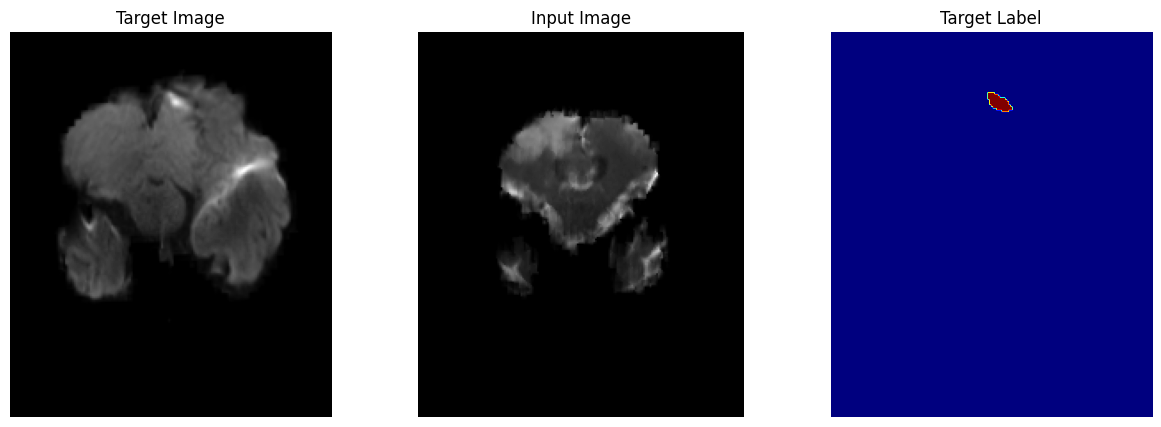

In [27]:
slice_number = 50  # Change this to the desired slice number

# Extract slices from the images
target_slice = target_img[:, :, slice_number]
input_slice = input_img[:, :, slice_number]
target_label_slice = target_label[:, :, slice_number]

# Create subplots for the three images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the target image slice
axes[0].imshow(sitk.GetArrayViewFromImage(target_slice), cmap='gray')
axes[0].set_title('Target Image')

# Plot the input image slice
axes[1].imshow(sitk.GetArrayViewFromImage(input_slice), cmap='gray')
axes[1].set_title('Input Image')

# Plot the target label slice
axes[2].imshow(sitk.GetArrayViewFromImage(target_label_slice), cmap='jet')
axes[2].set_title('Target Label')

# Add axis labels and show the plot
for ax in axes:
    ax.axis('off')

plt.show()


In [28]:
label_result , result_img, result_transform_parameters,ct_img= coRegis_fix(input_img, target_img, target_label)

(98.0, 134.0, -72.0)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(197, 233, 189)
(197, 233, 189)
fixed_ori_direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
moving_ori_direction:  (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
Fixed size  (197, 233, 189)
Moving size  (181, 217, 181)
Moving Resampled size (197, 233, 189)
Label Resampled size (197, 233, 189)
Fixed space  (1.0, 1.0, 1.0)
Moving space  (1.0, 1.0, 1.0)
Resampled space (1.0, 1.0, 1.0)
Label Resampled space (1.0, 1.0, 1.0)
Fixed origin  (98.0, 134.0, -72.0)
Moving origin  (-91.0, 109.0, -91.0)
Moving Resampled origin  (98.0, 134.0, -72.0)
Label Resampled origin (98.0, 134.0, -72.0)
moving to this line
itk_fix origin  itkPointD3 ([98, 134, -72])
itk_fix_direction  itkMatrixD33 ([[-1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, 1.0]])
itk_fix spacing  itkVectorD3 ([1, 1, 1])
itk_mov origin  itkPointD3 ([98, 134, -72])
itk_mov spacing  itkVectorD3 ([1, 1, 1])
itk_mov_direc

In [29]:
!pwd

# sitk.WriteImage(label_result,f'2224_2564111995_label.nii.gz')
# sitk.WriteImage(result_img,f'2224_2564111995_mri.nii.gz')

# sitk.WriteImage(ct_img,f'/scratch4/rsteven1/New_MRI/2224_2564111995/2224_2564111995_label_MNI_coRegist.nii.gz')

/home/bruno/xfang/GenrativeMethod/co_regis


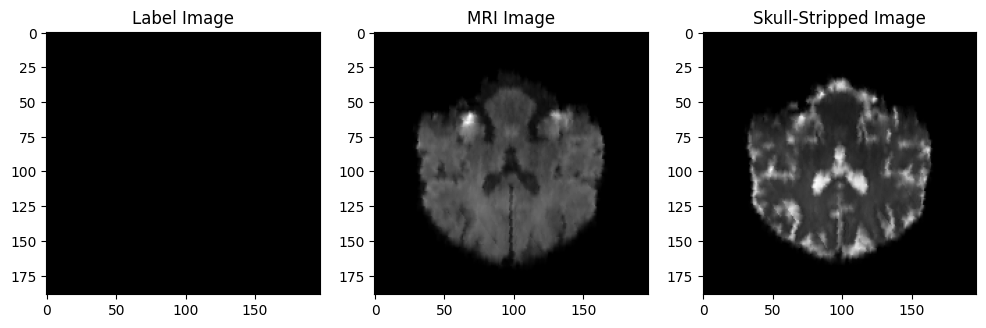

In [30]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Assuming you have already loaded your images as label_result, result_img, and ct_img

# Choose the slice you want to display (e.g., slice 0 for the first slice)
slice_idx = 110

# Extract the selected slices
label_slice = label_result[:, slice_idx, :]
result_slice = result_img[:, slice_idx, :]
ct_slice = ct_img[:, slice_idx, :]

# Plot the selected slices
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(sitk.GetArrayViewFromImage(label_slice), cmap='gray')
plt.title('Label Image')

plt.subplot(132)
plt.imshow(sitk.GetArrayViewFromImage(result_slice), cmap='gray')
plt.title('MRI Image')

plt.subplot(133)
plt.imshow(sitk.GetArrayViewFromImage(ct_slice), cmap='gray')
plt.title('Skull-Stripped Image')

plt.show()
